
# Analysing the MNIST dataset using Classification techniques

The MNIST database is a very large dataset of over 60000 handwritten digits each presented in a 28 x 28 pixel image. It has been used to train and test many machine learning techniques and many researcher have boasted "near human performance" on their algorithms.
This project is part of Kaggle's Digit recognizer competition, I will be using a variety of SciKit-learns classification models to try and achieve the highest possible accuracy.

## Visulizing the data

The data for this project can be downloaded [here](https://www.kaggle.com/c/digit-recognizer/data). The data is split up into test and train datasets with 28000 and 42000 digits in each. The test data will be revisited at the end for submission to Kaggle to get the final accuracy score.

Below I load the data and have diplayed a few digits as well as given a heat-map of the pixel activity

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time

In [2]:
# Load data
data = pd.read_csv('train.csv')
train = data.drop('label', 1)

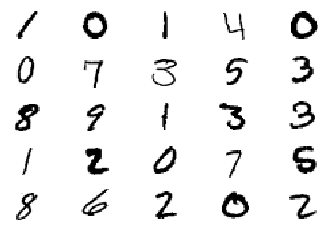

In [3]:
# Displaying some numbers and features
for i in range(25):
    plt.subplot(5,5,i + 1)
    img = train.iloc[i].values.reshape(28,28)
    plt.imshow(img, cmap = 'binary')
    plt.axis('off')


Text(0.5, 1.0, 'Pixel variance')

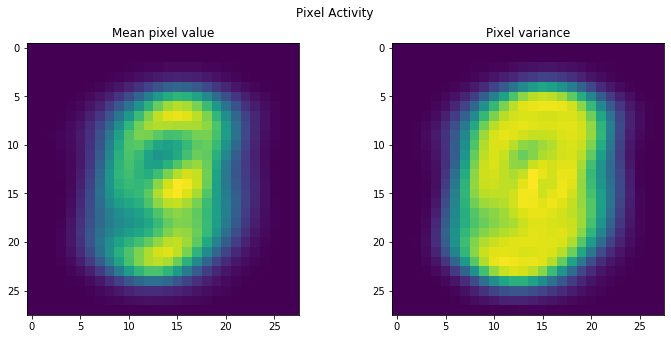

In [4]:
# Visulize pixel activity
heat_map = train.mean()
variance = train.var()
# plt.subplot(1,2,1, autoscalex_on = True)
# plt.imshow(heat_map.values.reshape(28,28))
# plt.subplot(1,2,2,autoscalex_on = True)
# plt.imshow(variance.values.reshape(28,28))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,5))
fig.suptitle('Pixel Activity')
ax1.imshow(heat_map.values.reshape(28,28))
ax1.set_title('Mean pixel value')
ax2.imshow(variance.values.reshape(28,28))
ax2.set_title('Pixel variance')

## Random Forest

A Random forest is a collection of decision trees performed on subsets of the data, decision trees operate by recursively splitting the data along its most important feature untill all the data is best categorised. 
I'll be starting with this model as it does an good job of only using the features necessary, the plots above shows that many of the pixels have very little activity, decision trees will only consider the most active pixels to use. Hopefully it will give a good baseline accuracy to try and beat in the rest of the project.

In [5]:
# Import necessary functions
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

This function will used to fit and test the classifying models, below I use it to run an initial test on the Random Forest.

In [6]:
# classifier tester

def fit_score(classifier, data, labels, test_ratio = None, seed = None):
    data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size = test_ratio, random_state = seed)
    
    classifier.fit(data_train, labels_train)
    pred = classifier.predict(data_test)
    
    return accuracy_score(labels_test, pred)

In [7]:
# Initial test 

clf_forest = RandomForestClassifier()

fit_score(clf_forest, train, data['label'])

C:\Users\Lang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9374285714285714

Thats not bad at all, this was only using 10 trees in the forest however. I want to experiment to see if increasing the number of trees leads to a significant increase in accuracy. For the sake of time I'll only use the first 1000 digits the dataset:

In [8]:
# Varying the number of trees
trees = [1,2,5,10,20,50,100,200,300,500,750,1000]
trees_df = pd.DataFrame(index = trees, columns = ['Accuracy', 'Time'])
for i in trees:
    t0 = time()
    clf = RandomForestClassifier(i)
    accuracy = fit_score(clf, train.iloc[:1000], data['label'].iloc[:1000], seed = 0)
    trees_df.at[i,'Accuracy'] = accuracy
    trees_df.at[i, 'Time'] = time() - t0

print(trees_df)

     Accuracy       Time
1       0.516  0.0658216
2       0.604  0.0520029
5       0.676  0.0468652
10      0.776  0.0937283
20      0.864   0.158981
50      0.884   0.327129
100     0.884   0.663993
200     0.892    1.11537
300     0.892    1.59319
500     0.908     2.4613
750     0.912    3.53992
1000     0.92    4.76789


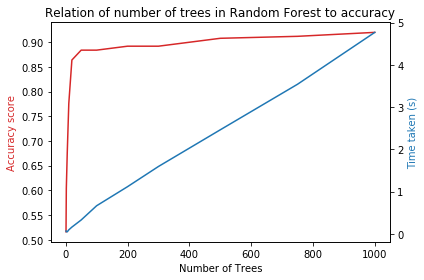

In [9]:
x = trees_df.index.values
fig, ax1 = plt.subplots()
plt.title('Relation of number of trees in Random Forest to accuracy')

color = 'tab:red'
ax1.set_xlabel('Number of Trees')
ax1.set_ylabel('Accuracy score', color=color)
ax1.plot(x, trees_df['Accuracy'], color=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Time taken (s)', color=color)  
ax2.plot(x, trees_df['Time'], color=color)

fig.tight_layout()  
plt.show()

It appears that the accuracy plateaus at approximately 0.9 (this was lower than the intial run due to the smaller training dataset) whereas the time taken for the training increased linearly. 
I've decided to set the number of trees at 200, below I test the performance for the Random Forest on the full testing dataset.

In [10]:
t0 = time()
clf_RF = RandomForestClassifier(200)
accuracy = fit_score(clf_RF, train, data['label'])
print(f'RandomForestClassifier got an accuracy score of {accuracy} \nTime taken: {time() - t0} seconds')

RandomForestClassifier got and accuracy score of 0.9645714285714285 
Time taken: 63.50767779350281 seconds


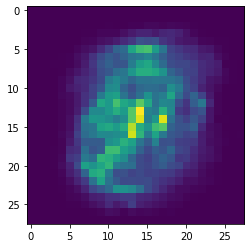

In [11]:
# Display the feature importances for the Random Forest Classifier
plt.imshow(clf.feature_importances_.reshape(28,28))

0.964 is pretty impressive for now. The feature importances of the model show that only some of the pixels were really used, it makes sense to do some feature reduction before trying out some of the other classifiers

## Principal Component Analysis

PCA is a dimensionality reduction technique that performs a linear mapping to data to a lower-dimensional space, but done in such a way that the variance of the data in the low-dimensional representation is maximized. 

In [12]:
# Import functions
from sklearn.decomposition import PCA

In [13]:
# Test PCA by reducing to 2 components
pca = PCA(n_components = 2)
pca.fit(train)

d_2 = pca.transform(train)
print(d_2)

[[-661.59564503 -699.31024709]
 [1701.45149064 -360.55223507]
 [-886.89454225 -293.76464428]
 ...
 [ 336.26996714  950.01523443]
 [ 327.39936709   62.01408608]
 [-364.24908591  418.89037598]]


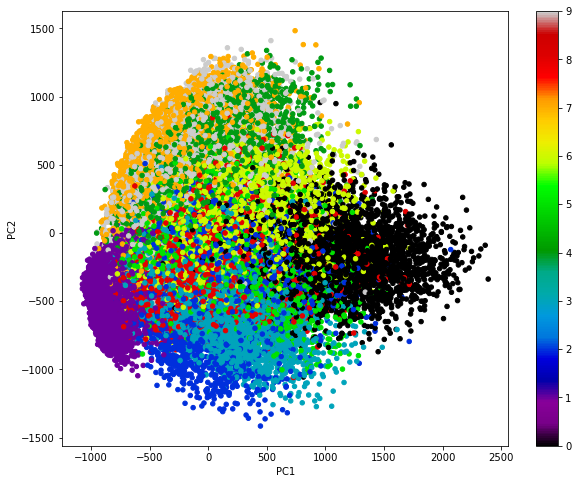

In [46]:
# Plot 2 components 
plt.figure(figsize=(10, 8))
plt.scatter(d_2[:,0],d_2[:,1], s=20, c = data['label'], cmap = "nipy_spectral")
plt.colorbar()

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Even with only two components we can see a separation of the different numbers, although there still remains large overlaps for similar looking digits such as 2 and 3. Lets inspect the `explained_variance_ratio_` attribute of the PCA to find out how much information is retained with each dimensionality reduction:

In [15]:
# Fit PCA on data
pca = PCA()
pca.fit(train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

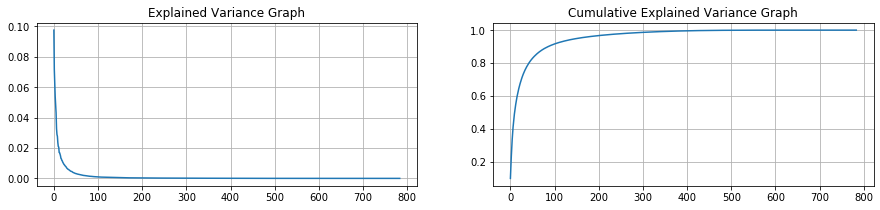

In [16]:
f = plt.figure(figsize=(15,3))

ax = f.add_subplot(121)
ax.plot(pca.explained_variance_ratio_)
ax.set_title("Explained Variance Graph")
ax.grid()

ax2 = f.add_subplot(122)
ax2.plot(np.cumsum(pca.explained_variance_ratio_))
ax2.set_title("Cumulative Explained Variance Graph")
ax2.grid()

It appears we only need approximately the first 400 components of the transformation to reflect all of the variance and the first 100 to capture 90% of it. This was expected however as many of the pixels around the corners where consistently blank. 

Lets try and visualise the first few of these eigenvectors:

In [115]:
# Apply the transformation
data_pca = pd.DataFrame(pca.transform(train))

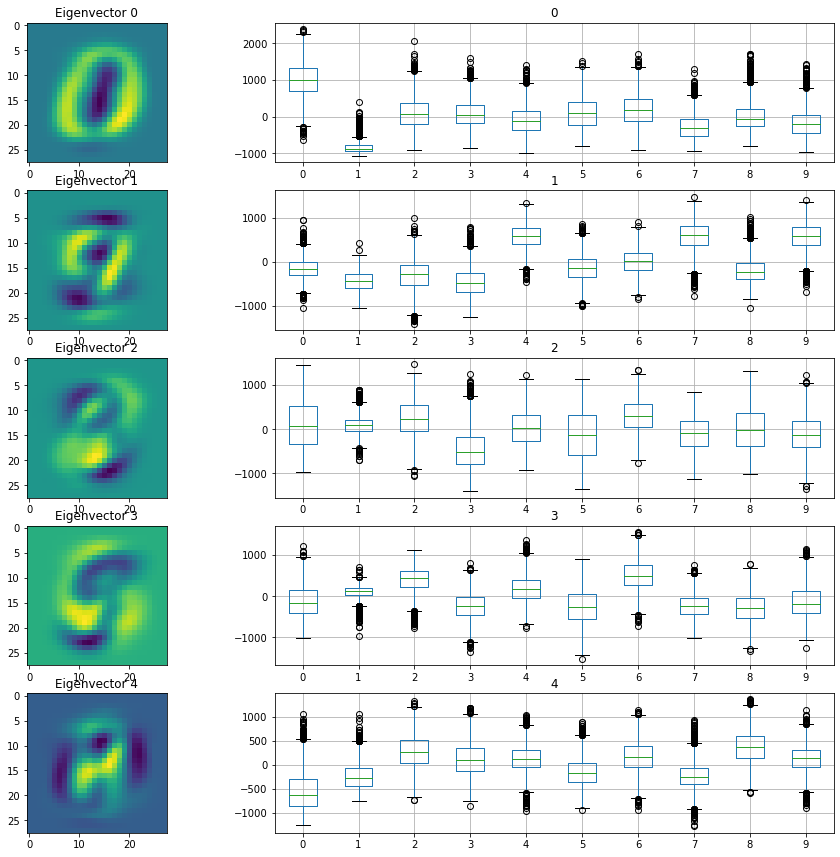

In [45]:
f = plt.figure(figsize=(15,15))
gs = f.add_gridspec(5,3)
for i in range(5):
    img = f.add_subplot(gs[i,0])
    img.set_title('Eigenvector ' + str(i))
    img.imshow(pca.components_[i,:].reshape(28,28))
    box = f.add_subplot(gs[i,1:])
    data_pca.boxplot(column = i, by = data['label'], ax = box )
    plt.suptitle('')
    plt.xlabel('')

We can see that the first eigenvector has a heavy correlation with the 0 and 1 digits, with the majority of the 0's taking high values along this component and the 1's taking small values. 
Similar patterns can be seen for the other eigenvalues (you can notice a 9 or 4 appearing in the second one and a 3 appearing in the third!).

For the next few classifiers I'll be using the first 200 components (reduced down from 784) as it accounts for 95% of the variance.

In [116]:
data_pca = data_pca.iloc[:,:200]

## K Nearest Neigbours

The K Nearest Neigbours classifier operates simpily by classifying based on the K *nearest* (default measurement in Euclidean metric) training samples. This should be an effective algorithm judging by the clustering witnessed in the 2 component PCA reduction plot.

Here I'll experiment by changing the value of K and changing the weights of the neighbours between `uniform` and `distance`:

In [76]:
from sklearn.neighbors import KNeighborsClassifier

In [74]:
K = [1,3,5,10,15,20,30,50,75,100]
KNN_df = pd.DataFrame({'K':K,'key':[1]*len(K)}).merge(pd.DataFrame({'weight':['uniform','distance'], 'key': [1,1]}), on = 'key')
KNN_df.drop('key', inplace = True, axis = 1)

for index, row in KNN_df.iterrows():
    print(row['K'])

1
1
3
3
5
5
10
10
15
15
20
20
30
30
50
50
75
75
100
100


In [117]:
# Compare different weights and values of K
K = [1,3,5,10,15,20,30,50,75,100]
KNN_df = pd.DataFrame({'K':K,'key':[1]*len(K)}).merge(pd.DataFrame({'weight':['uniform','distance'], 'key': [1,1]}, columns = ['weight','key','Accuracy', 'Time']), on = 'key')
KNN_df.drop('key', inplace = True, axis = 1)

for index, row in KNN_df.iterrows():
    t0 = time()
    clf = KNeighborsClassifier(n_neighbors = row['K'], weights = row['weight'])
    accuracy = fit_score(clf, data_pca.iloc[:1000], data['label'].iloc[:1000], seed = 0)
    KNN_df.at[index,'Accuracy'] = accuracy
    KNN_df.at[index, 'Time'] = time() - t0

print(KNN_df)

      K    weight Accuracy       Time
0     1   uniform    0.848   0.128067
1     1  distance    0.848  0.0937264
2     3   uniform     0.86  0.0781064
3     3  distance    0.868  0.0937302
4     5   uniform    0.868   0.110438
5     5  distance    0.872   0.102619
6    10   uniform    0.852    0.11639
7    10  distance    0.868   0.238498
8    15   uniform    0.816   0.171697
9    15  distance    0.824   0.107759
10   20   uniform    0.792   0.103429
11   20  distance    0.812   0.106742
12   30   uniform    0.772   0.104877
13   30  distance     0.78   0.103456
14   50   uniform     0.76   0.109845
15   50  distance    0.776  0.0952175
16   75   uniform      0.7  0.0937297
17   75  distance    0.716  0.0937269
18  100   uniform    0.672   0.129073
19  100  distance    0.692   0.109349


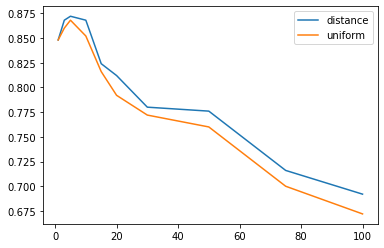

In [118]:
plt.plot(KNN_df[KNN_df['weight'] == 'distance']['K'],KNN_df[KNN_df['weight'] == 'distance']['Accuracy'], label = 'distance')
plt.plot(KNN_df[KNN_df['weight'] == 'uniform']['K'],KNN_df[KNN_df['weight'] == 'uniform']['Accuracy'], label = 'uniform')
plt.legend()

The best performer here was having the neighbours weighted based on `distance` and having the default 5 neighbours up for consideration. Lets see what score it gets using the rest of the training data:

In [119]:
t0 = time()
clf_KNN = KNeighborsClassifier(n_neighbors = 5, weights = 'distance')
accuracy = fit_score(clf_KNN, data_pca, data['label'])
print(f'KNeighborsClassifier got an accuracy score of {accuracy} \nTime taken: {time() - t0} seconds')

KNeighborsClassifier got and accuracy score of 0.9702857142857143 
Time taken: 192.40955805778503 seconds


A slight improvement on the Random Forest, although even with the PCA it took 3 times longer.

To Do:
 - Use SVM